In [1]:
import os
import time
import random

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertDataset, MLMDataset
from causal_bert import CausalBOW

In [2]:
bsz = 256
epoch = 50

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert effect == 'ate' and estimation == 'q', f'unallowed effect/estimation: {effect}/{estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_score.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi
        
def est_casual_effect(data_loader, model, effect='ate', estimation='q', eval_loss=True, **kwargs):
    # We use `real_treatment` here to emphasize the estimations use real instead of estimated treatment.
    real_response, real_treatment = [], []
    prop_scores, Q1, Q0 = [], [], []

    if eval_loss:
        g_loss = kwargs.get('g_loss')
        q_loss = kwargs.get('q_loss')
        g_loss_test, q1_loss_test, q0_loss_test  = [], [], []
    model.eval()
    for idx, (tokens, treatment, response) in enumerate(data_loader):
        real_response.append(response.cpu().data.numpy().squeeze())
        real_treatment.append(treatment.cpu().data.numpy().squeeze())

        prop_score, q1, q0 = model(tokens)
        
        prop_scores.append(prop_score.cpu().data.numpy().squeeze())
        Q1.append(q1.cpu().data.numpy().squeeze())
        Q0.append(q0.cpu().data.numpy().squeeze())
        
        if eval_loss:
            g_loss_val  = g_loss(prop_score, treatment)
            q1_loss_val = q_loss(q1[treatment==1], response[treatment==1])
            q0_loss_val = q_loss(q0[treatment==0], response[treatment==0])
            
            g_loss_test.append(g_loss_val.item())
            q1_loss_test.append(q1_loss_val.item())
            q0_loss_test.append(q0_loss_val.item())
            
    real_response = np.concatenate(real_response, axis=0)
    real_treatment = np.concatenate(real_treatment, axis=0)

    Q1 = np.concatenate(Q1, axis=0)
    Q0 = np.concatenate(Q0, axis=0)
    prop_scores = np.concatenate(prop_scores, axis=0)
    
    
    g_loss = np.array(g_loss_test).mean() if eval_loss else None
    q1_loss = np.array(q1_loss_test).mean() if eval_loss else None
    q0_loss = np.array(q0_loss_test).mean() if eval_loss else None

    model.train()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (real_treatment * (Q1 - Q0))
            return phi.sum() / real_treatment.sum(), g_loss, q1_loss, q0_loss
        elif effect == 'ate':
            return (Q1 - Q0).mean(), g_loss, q1_loss, q0_loss

    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / real_treatment.mean(), g_loss, q1_loss, q0_loss
        elif effect == 'ate':
            return phi, g_loss, q1_loss, q0_loss
        

def show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch):
    train_loss_hist = np.array(train_loss_hist)
    test_loss_hist = np.array(test_loss_hist)
    est_effect = np.array(est_effect)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lns1 = ax.plot(np.arange(epoch), test_loss_hist, label='test loss')

    ax_r = plt.twinx()
    lns2 = ax_r.plot(np.arange(epoch), est_effect, color='coral', label='estimate ATE')
    lns3 = ax_r.plot(np.arange(epoch), np.ones(epoch) * real, color='red', ls='--', label='real ATE')
    lns4 = ax_r.plot(np.arange(epoch), np.ones(epoch) * unadjust, color='green', ls='--', label='unadjusted ATE')

    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    ax_r.legend(lns, labs, loc=0)
    plt.show()
    

# LOW

In [5]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

alpha = 0.25
beta = 1.
c = 0.2
i = 0.

In [6]:
start = time.time()
trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                             alpha=alpha, beta=beta, c=c, i=i, 
                             group=list(range(1)), max_length=512, min_length=10,
                             truncate_method='first', device=device, seed=1)

print(f'Load training set in {(time.time() - start):.2f} sec')

start = time.time()
testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                            alpha=alpha, beta=beta, c=c, i=i, 
                            group=[9], max_length=512, min_length=10,
                            truncate_method='first', device=device)

print(f'Load validation set in {(time.time() - start):.2f} sec')

Load training set in 77.05 sec
Load validation set in 69.25 sec


In [7]:
train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, batch_size=2048, drop_last=True, shuffle=True)

In [8]:
real_att_q = true_casual_effect(test_loader)

print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

Real: [effect: ate], [estimation: q], [value: 0.06317]
Unadjusted: [value: 0.0919]


In [9]:
trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'

model = BertForMaskedLM.from_pretrained(trained_bert)
token_embed = model.get_input_embeddings()
model = CausalBOW(token_embed, learnable_docu_embed=False, hidden_size=64, prop_is_logit=True).to(device)

pos_portion = trainset.treatment.mean()
pos_weight = (1 - pos_portion) / pos_portion

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epoch_iter = len(train_loader)
total_steps = epoch * epoch_iter

optimizer = AdamW(model.parameters(), lr=1e-4, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

q_loss = nn.BCELoss()
# prop_score_loss = nn.BCELoss()
prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Please specify the effect and estimation we want to use here.
effect = 'ate'
estimation = 'q'

effect = effect.lower()
estimation = estimation.lower()
assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [10]:
rs_loss, rq1_loss, rq0_loss = [0.] * 3

train_loss_hist, test_loss_hist, est_effect = [], [], []
for e in range(1, epoch + 1):
    model.train()
    start = time.time()
    run_loss = 0.
    for idx, (tokens, treatment, response) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss = prop_score_loss(prop_score, treatment)
        if len(response[treatment == 1]) > 0:
            loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
        if len(response[treatment == 0]) > 0:
            loss += q_loss(q0[treatment==0], response[treatment==0])
            
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        optimizer.step()
        scheduler.step()

        run_loss += loss.item()
        
    run_idx = idx

    # Evaluation.
    train_loss = run_loss / (run_idx + 1)
    train_effect, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, eval_loss=False)
    test_effect, g_loss_test, q1_loss_test, q0_loss_test = est_casual_effect(test_loader, model, effect, estimation, g_loss=prop_score_loss, q_loss=q_loss)
    test_loss = q1_loss_test + q0_loss_test
    test_loss += g_loss_test
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    est_effect.append(test_effect)
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
          Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()
    run_loss = 0.

print('Finish training...')

# With only 1 group(s) to train.

epoch: 1 / 50, time cost: 37.94 sec, 
          Loss: [Train: 2.42558], [Test: 2.42819],
          Effect: [ate-q], [train: 0.09110], [test: 0.09109]
********************************************************************************
epoch: 2 / 50, time cost: 44.35 sec, 
          Loss: [Train: 2.42159], [Test: 2.42457],
          Effect: [ate-q], [train: 0.07831], [test: 0.07831]
********************************************************************************
epoch: 3 / 50, time cost: 42.40 sec, 
          Loss: [Train: 2.41701], [Test: 2.42027],
          Effect: [ate-q], [train: 0.08075], [test: 0.08075]
********************************************************************************
epoch: 4 / 50, time cost: 42.39 sec, 
          Loss: [Train: 2.41193], [Test: 2.41598],
          Effect: [ate-q], [train: 0.09175], [test: 0.09176]
********************************************************************************
epoch: 5 / 50, time cost: 42.39 sec, 
          Loss: [Train: 2.40683], [Tes

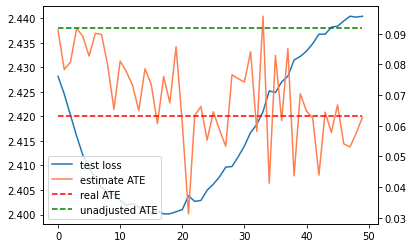

In [11]:
real = true_casual_effect(test_loader)
unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)

# Med

In [12]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

alpha = 0.25
beta = 5.
c = 0.2
i = 0.

In [13]:
start = time.time()
trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                             alpha=alpha, beta=beta, c=c, i=i, 
                             group=list(range(1)), max_length=512, min_length=10,
                             truncate_method='first', device=device, seed=1)

print(f'Load training set in {(time.time() - start):.2f} sec')

start = time.time()
testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                            alpha=alpha, beta=beta, c=c, i=i, 
                            group=[9], max_length=512, min_length=10,
                            truncate_method='first', device=device)

print(f'Load validation set in {(time.time() - start):.2f} sec')

Load training set in 68.91 sec
Load validation set in 66.82 sec


In [14]:
train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, batch_size=2048, drop_last=True, shuffle=True)

In [15]:
real_att_q = true_casual_effect(test_loader)

print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

Real: [effect: ate], [estimation: q], [value: 0.06024]
Unadjusted: [value: 0.1403]


In [16]:
trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'

model = BertForMaskedLM.from_pretrained(trained_bert)
token_embed = model.get_input_embeddings()
model = CausalBOW(token_embed, learnable_docu_embed=False, hidden_size=64, prop_is_logit=True).to(device)

pos_portion = trainset.treatment.mean()
pos_weight = (1 - pos_portion) / pos_portion

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epoch_iter = len(train_loader)
total_steps = epoch * epoch_iter

optimizer = AdamW(model.parameters(), lr=1e-4, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

q_loss = nn.BCELoss()
# prop_score_loss = nn.BCELoss()
prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Please specify the effect and estimation we want to use here.
effect = 'ate'
estimation = 'q'

effect = effect.lower()
estimation = estimation.lower()
assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [17]:
rs_loss, rq1_loss, rq0_loss = [0.] * 3

train_loss_hist, test_loss_hist, est_effect = [], [], []
for e in range(1, epoch + 1):
    model.train()
    start = time.time()
    run_loss = 0.
    for idx, (tokens, treatment, response) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss = prop_score_loss(prop_score, treatment)
        if len(response[treatment == 1]) > 0:
            loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
        if len(response[treatment == 0]) > 0:
            loss += q_loss(q0[treatment==0], response[treatment==0])
            
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        optimizer.step()
        scheduler.step()

        run_loss += loss.item()
        
    run_idx = idx

    # Evaluation.
    train_loss = run_loss / (run_idx + 1)
    train_effect, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, eval_loss=False)
    test_effect, g_loss_test, q1_loss_test, q0_loss_test = est_casual_effect(test_loader, model, effect, estimation, g_loss=prop_score_loss, q_loss=q_loss)
    test_loss = q1_loss_test + q0_loss_test
    test_loss += g_loss_test
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    est_effect.append(test_effect)
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
          Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()
    run_loss = 0.

print('Finish training...')

# With only 1 group(s) to train.

epoch: 1 / 50, time cost: 38.64 sec, 
          Loss: [Train: 2.39876], [Test: 2.40096],
          Effect: [ate-q], [train: 0.13630], [test: 0.13628]
********************************************************************************
epoch: 2 / 50, time cost: 42.78 sec, 
          Loss: [Train: 2.39190], [Test: 2.39500],
          Effect: [ate-q], [train: 0.12067], [test: 0.12066]
********************************************************************************
epoch: 3 / 50, time cost: 42.01 sec, 
          Loss: [Train: 2.38150], [Test: 2.38154],
          Effect: [ate-q], [train: 0.12537], [test: 0.12540]
********************************************************************************
epoch: 4 / 50, time cost: 42.31 sec, 
          Loss: [Train: 2.36488], [Test: 2.36824],
          Effect: [ate-q], [train: 0.12129], [test: 0.12146]
********************************************************************************
epoch: 5 / 50, time cost: 41.29 sec, 
          Loss: [Train: 2.35234], [Tes

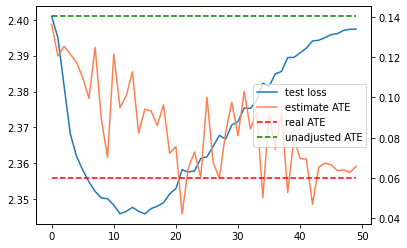

In [18]:
real = true_casual_effect(test_loader)
unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)

# High

In [19]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

alpha = 0.75
beta = 25.
c = 0.2
i = 0.

In [20]:
start = time.time()
trainset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                             alpha=alpha, beta=beta, c=c, i=i, 
                             group=list(range(1)), max_length=512, min_length=10,
                             truncate_method='first', device=device, seed=1)

print(f'Load training set in {(time.time() - start):.2f} sec')

start = time.time()
testset = CausalBertDataset(tokenizer=tokenizer, data_type='merged', is_unidiag=True,
                            alpha=alpha, beta=beta, c=c, i=i, 
                            group=[9], max_length=512, min_length=10,
                            truncate_method='first', device=device)

print(f'Load validation set in {(time.time() - start):.2f} sec')

Load training set in 70.09 sec
Load validation set in 65.94 sec


In [21]:
train_loader = DataLoader(trainset, batch_size=bsz, drop_last=True, shuffle=True)
test_loader = DataLoader(testset, batch_size=2048, drop_last=True, shuffle=True)

In [22]:
real_att_q = true_casual_effect(test_loader)

print(f'Real: [effect: ate], [estimation: q], [value: {real_att_q:.5f}]')
print(f'Unadjusted: [value: {(testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item():.4f}]')

Real: [effect: ate], [estimation: q], [value: 0.16917]
Unadjusted: [value: 0.2379]


In [23]:
trained_bert = '/nfs/turbo/lsa-regier/bert-results/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'
# trained_bert = '/home/liutianc/emr/bert/results/behrt/MLM/merged/unidiag/checkpoint-6018425/'

model = BertForMaskedLM.from_pretrained(trained_bert)
token_embed = model.get_input_embeddings()
model = CausalBOW(token_embed, learnable_docu_embed=False, hidden_size=64, prop_is_logit=True).to(device)

pos_portion = trainset.treatment.mean()
pos_weight = (1 - pos_portion) / pos_portion

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epoch_iter = len(train_loader)
total_steps = epoch * epoch_iter

optimizer = AdamW(model.parameters(), lr=1e-4, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

q_loss = nn.BCELoss()
# prop_score_loss = nn.BCELoss()
prop_score_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Please specify the effect and estimation we want to use here.
effect = 'ate'
estimation = 'q'

effect = effect.lower()
estimation = estimation.lower()
assert effect in ['att', 'ate'], f'Wrong effect: {effect}...'
assert estimation in ['q', 'plugin'], f'Wrong estimation: {estimation}...'

In [24]:
rs_loss, rq1_loss, rq0_loss = [0.] * 3

train_loss_hist, test_loss_hist, est_effect = [], [], []
for e in range(1, epoch + 1):
    model.train()
    start = time.time()
    run_loss = 0.
    for idx, (tokens, treatment, response) in enumerate(train_loader):
        optimizer.zero_grad()
        prop_score, q1, q0 = model(tokens)
        
        loss = prop_score_loss(prop_score, treatment)
        if len(response[treatment == 1]) > 0:
            loss += q_loss(q1[treatment==1], response[treatment==1])# * pos_weight
            
        if len(response[treatment == 0]) > 0:
            loss += q_loss(q0[treatment==0], response[treatment==0])
            
        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        optimizer.step()
        scheduler.step()

        run_loss += loss.item()
        
    run_idx = idx

    # Evaluation.
    train_loss = run_loss / (run_idx + 1)
    train_effect, _, _, _ = est_casual_effect(train_loader, model, effect, estimation, eval_loss=False)
    test_effect, g_loss_test, q1_loss_test, q0_loss_test = est_casual_effect(test_loader, model, effect, estimation, g_loss=prop_score_loss, q_loss=q_loss)
    test_loss = q1_loss_test + q0_loss_test
    test_loss += g_loss_test
    
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    est_effect.append(test_effect)
    print(f'''epoch: {e} / {epoch}, time cost: {(time.time() - start):.2f} sec, 
          Loss: [Train: {train_loss:.5f}], [Test: {test_loss:.5f}],
          Effect: [{effect}-{estimation}], [train: {train_effect:.5f}], [test: {test_effect:.5f}]''')
    print('*'* 80)
    start = time.time()
    run_loss = 0.

print('Finish training...')

# With only 1 group(s) to train.

epoch: 1 / 50, time cost: 41.72 sec, 
          Loss: [Train: 2.32171], [Test: 2.31952],
          Effect: [ate-q], [train: 0.24148], [test: 0.24146]
********************************************************************************
epoch: 2 / 50, time cost: 43.65 sec, 
          Loss: [Train: 2.30695], [Test: 2.31439],
          Effect: [ate-q], [train: 0.23023], [test: 0.23022]
********************************************************************************
epoch: 3 / 50, time cost: 43.05 sec, 
          Loss: [Train: 2.29984], [Test: 2.30706],
          Effect: [ate-q], [train: 0.23794], [test: 0.23794]
********************************************************************************
epoch: 4 / 50, time cost: 43.31 sec, 
          Loss: [Train: 2.29006], [Test: 2.29687],
          Effect: [ate-q], [train: 0.22880], [test: 0.22885]
********************************************************************************
epoch: 5 / 50, time cost: 43.08 sec, 
          Loss: [Train: 2.27779], [Tes

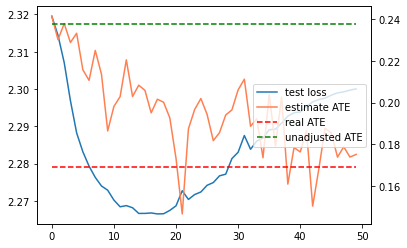

In [25]:
real = true_casual_effect(test_loader)
unadjust = (testset.response[testset.treatment == 1].mean() - testset.response[testset.treatment == 0].mean()).item()
show_result(train_loss_hist, test_loss_hist, est_effect, real, unadjust, epoch)